In [1]:
from Bio import Nexus, Phylo, SeqIO
from collections import defaultdict
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pathlib import Path

from itertools import combinations
from evaluation_helpers import *

# Evaluate estimation of population size with skyline / constant coalescent prior in BEAST

In [2]:
input_csv = "../scripts/successful_mcmc_runs.csv" 
df = process_results(input_csv)
df.head()

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...


In [13]:
log_test_path = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/expgrowth_fast/highmutsig/skyline_homochronous_expgrowth_fast_highmutsig.T0.log"
log_test_path_coal = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/constcoal/expgrowth_fast/highmutsig/constcoal_homochronous_expgrowth_fast_highmutsig.T0.log"
get_median_population_size(log_test_path, burnin=0.1, mode="skyline")

array([1549.54204976, 1208.29550732, 2090.28389111, 1345.28993689,
       1287.02260996, 1865.87780014, 1936.18039212, 1317.38426382,
       1516.8667167 , 1000.46516697])

In [14]:
tree_test_path = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/expgrowth_fast/highmutsig/skyline_homochronous_expgrowth_fast_highmutsig.T0.tree"
tree_test = Phylo.read(tree_test_path, "nexus")

In [15]:
get_skyline_group_boundaries(tree_test, num_groups=10)

[1.5031879938469501,
 2.825459449616119,
 6.2356139000062285,
 8.879562994976823,
 12.4962551931485,
 18.935906881068377,
 32.73432499026467,
 52.81856882193597,
 113.41847337937043,
 795.4148294613499]

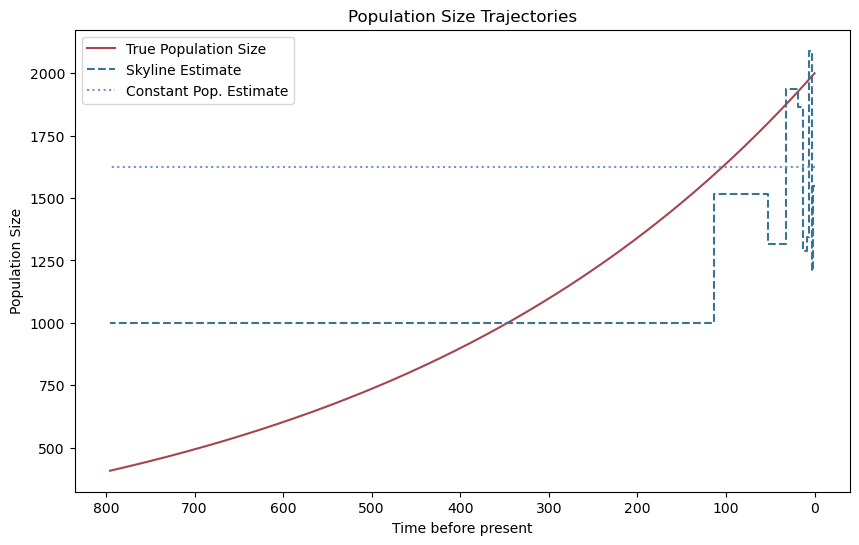

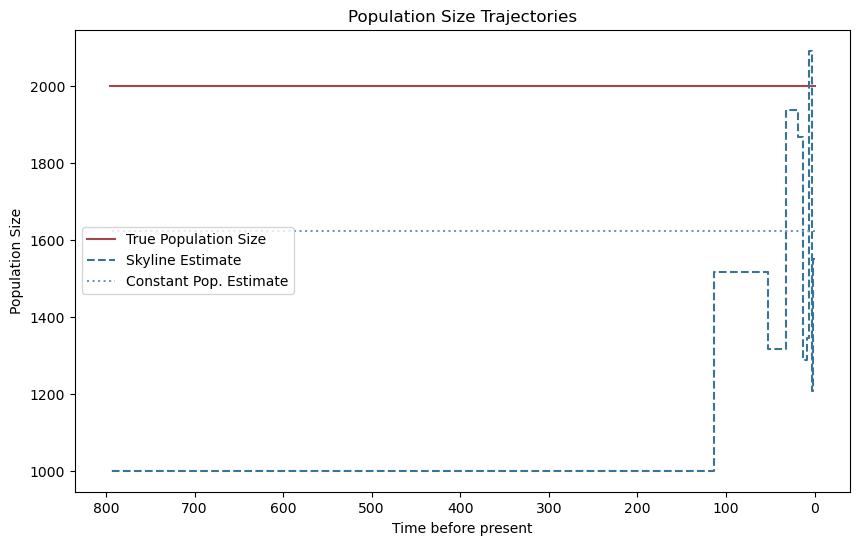

In [ ]:
def plot_population_trajectories(skyline_times, skyline_medians, constant_pop_estimate, present_pop_size, growth_rate = None):
    """
    Plots:
    - Exponential population growth (true)
    - Stepwise skyline population size estimates
    - Constant population estimate (overall median)
    
    Parameters:
        skyline_times (list): End time points of skyline intervals (backward in time, ascending).
        skyline_medians (list): Median population sizes for each interval.
        present_pop_size (float): True present-day population size (N0).
        growth_rate (float): Exponential growth rate (r).
        constant_pop_estimate (float): Overall median population size.
    """
    root_height = skyline_times[-1]  # The last time point is the root height (earliest time)

    # True exponential function (from root to present, i.e., from T to 0)
    t_vals = np.linspace(0, root_height, 1000)
    N_true = present_pop_size * np.exp(-growth_rate * t_vals)

    # Stepwise skyline values
    skyline_start_times = [0.0] + skyline_times[:-1]
    skyline_end_times = skyline_times
    step_times = []
    step_values = []

    for start, end, value in zip(skyline_start_times, skyline_end_times, skyline_medians):
        step_times.extend([start, end])
        step_values.extend([value, value])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, N_true, label="True Population Size", color = '#a6444f')
    plt.plot(step_times, step_values, drawstyle='steps-post', label="Skyline Estimate", linestyle = "--", color = "#397398")
    plt.hlines(constant_pop_estimate, 0, root_height, color='#7394c2', linestyle=':', label="Constant Pop. Estimate")

    plt.xlabel("Time before present")
    plt.ylabel("Population Size")
    plt.title("Population Size Trajectories")
    plt.legend()
    plt.gca().invert_xaxis()  # show present (0) on the right
    plt.show()


skyline_times = get_skyline_group_boundaries(tree_test, num_groups=10)
skyline_medians, _, _ = get_median_population_size(log_test_path, burnin=0.1, mode="skyline")
coalescent_median, _, _ = get_median_population_size(log_test_path_coal, burnin=0.1, mode="constcoal")

plot_population_trajectories(skyline_times, skyline_medians, 
                             present_pop_size=2000, growth_rate=0.002, 
                             constant_pop_estimate=coalescent_median)

plot_population_trajectories(skyline_times, skyline_medians, 
                             present_pop_size=2000, growth_rate=0, 
                             constant_pop_estimate=coalescent_median)


In [36]:
df_ = df.dropna()
df_ = add_tree_information(df_)
# 1min 15s

In [37]:
df_.head()

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline,skyline_medians,skyline_times,coalescent_median,skyline_lowers,skyline_uppers,coalescent_lower,coalescent_upper
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1549.5420497587572, 1208.2955073155356, 2090....","[1.5031879938469501, 2.825459449616119, 6.2356...",1623.217071,"[861.7829176870504, 463.4224987260407, 826.756...","[2667.7501649986366, 2602.9904562093757, 3610....",1431.448518,1853.763328
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2599.2202372887537, 2154.8986913825697, 2301....","[2.4304536409420052, 4.878242197413556, 8.3809...",1957.851751,"[1565.0379558067418, 883.0978040820994, 903.74...","[4286.46909049141, 4139.439819822707, 4231.942...",1727.382206,2231.741623
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2688.01735649332, 1352.1973882822972, 1511.50...","[2.4336367009808555, 4.3274500237843085, 6.082...",1993.191423,"[1662.7977122933119, 474.25767382166055, 661.0...","[4341.962030984948, 2807.4265670153645, 2782.8...",1760.307875,2273.912585
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1793.8474528508673, 1895.2618395529505, 2350....","[1.688498162637643, 3.930649310852914, 7.19952...",1900.630980,"[1041.4335012127112, 784.5343962480956, 865.94...","[3089.732546075335, 3560.589344728897, 4136.78...",1674.790128,2174.730413
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1680.1590236804636, 1684.305959318696, 2227.8...","[1.584076672179549, 3.069221429993945, 7.06828...",1703.652888,"[946.5527309666168, 697.3525369177987, 927.780...","[2904.2999349138845, 3201.4293148966044, 3892....",1496.146341,1942.558335


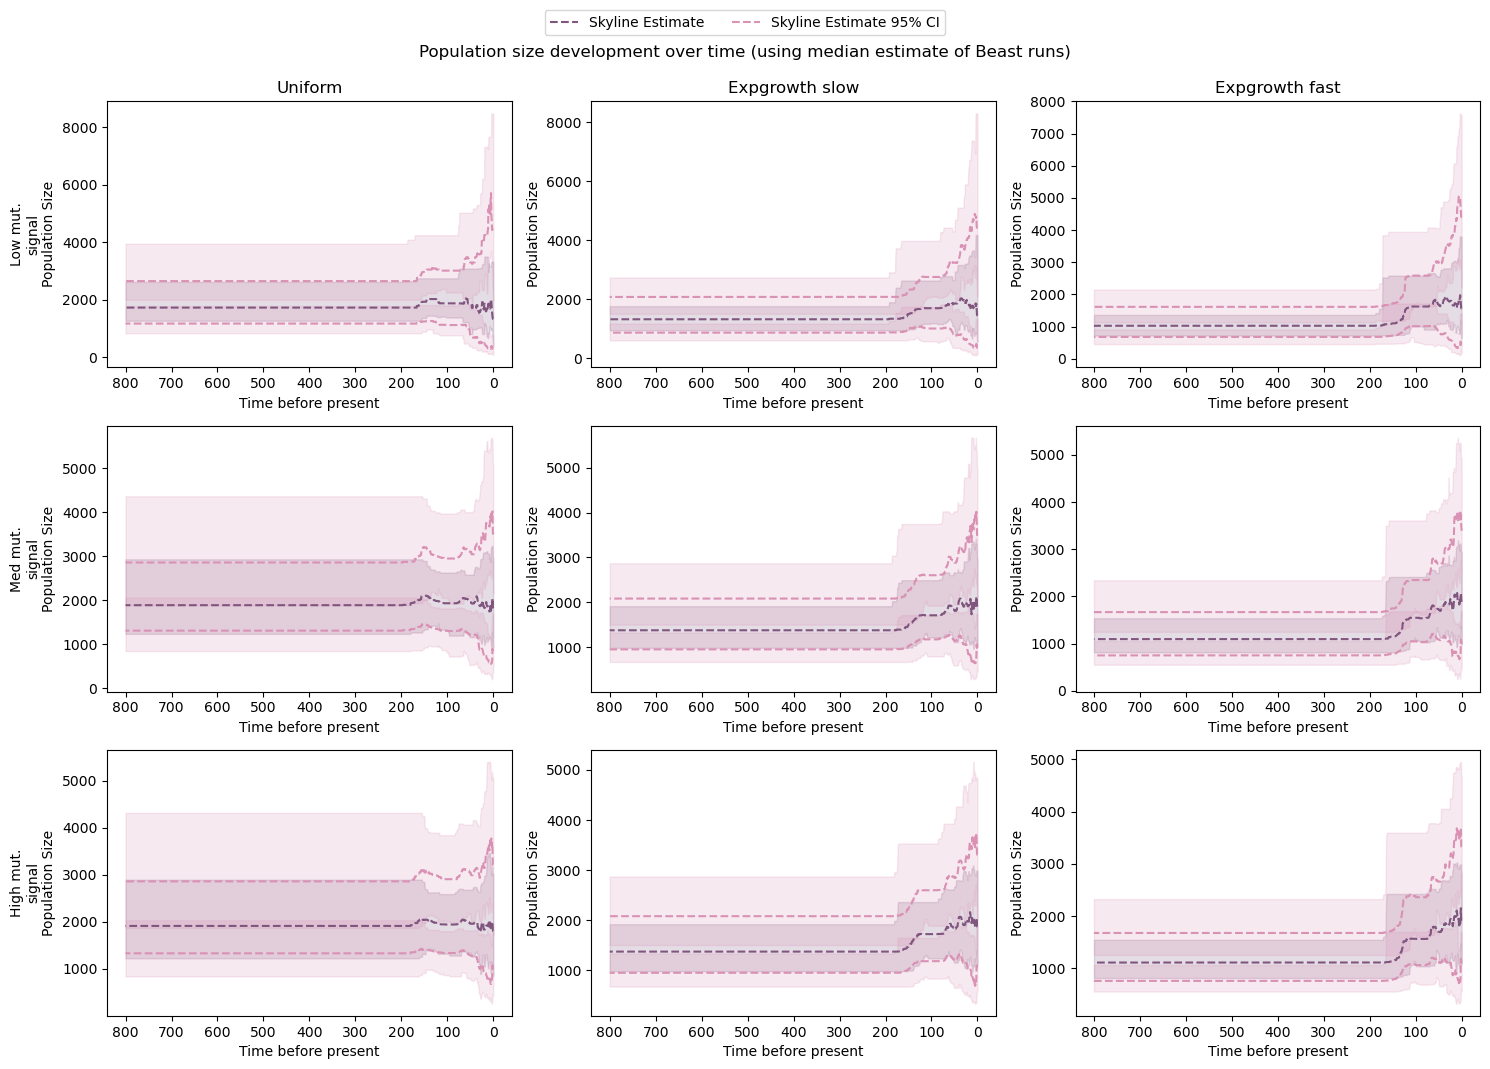

In [74]:
plot_population_summary_95cf(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)', mode = 'skyline', plot_true_size=False)

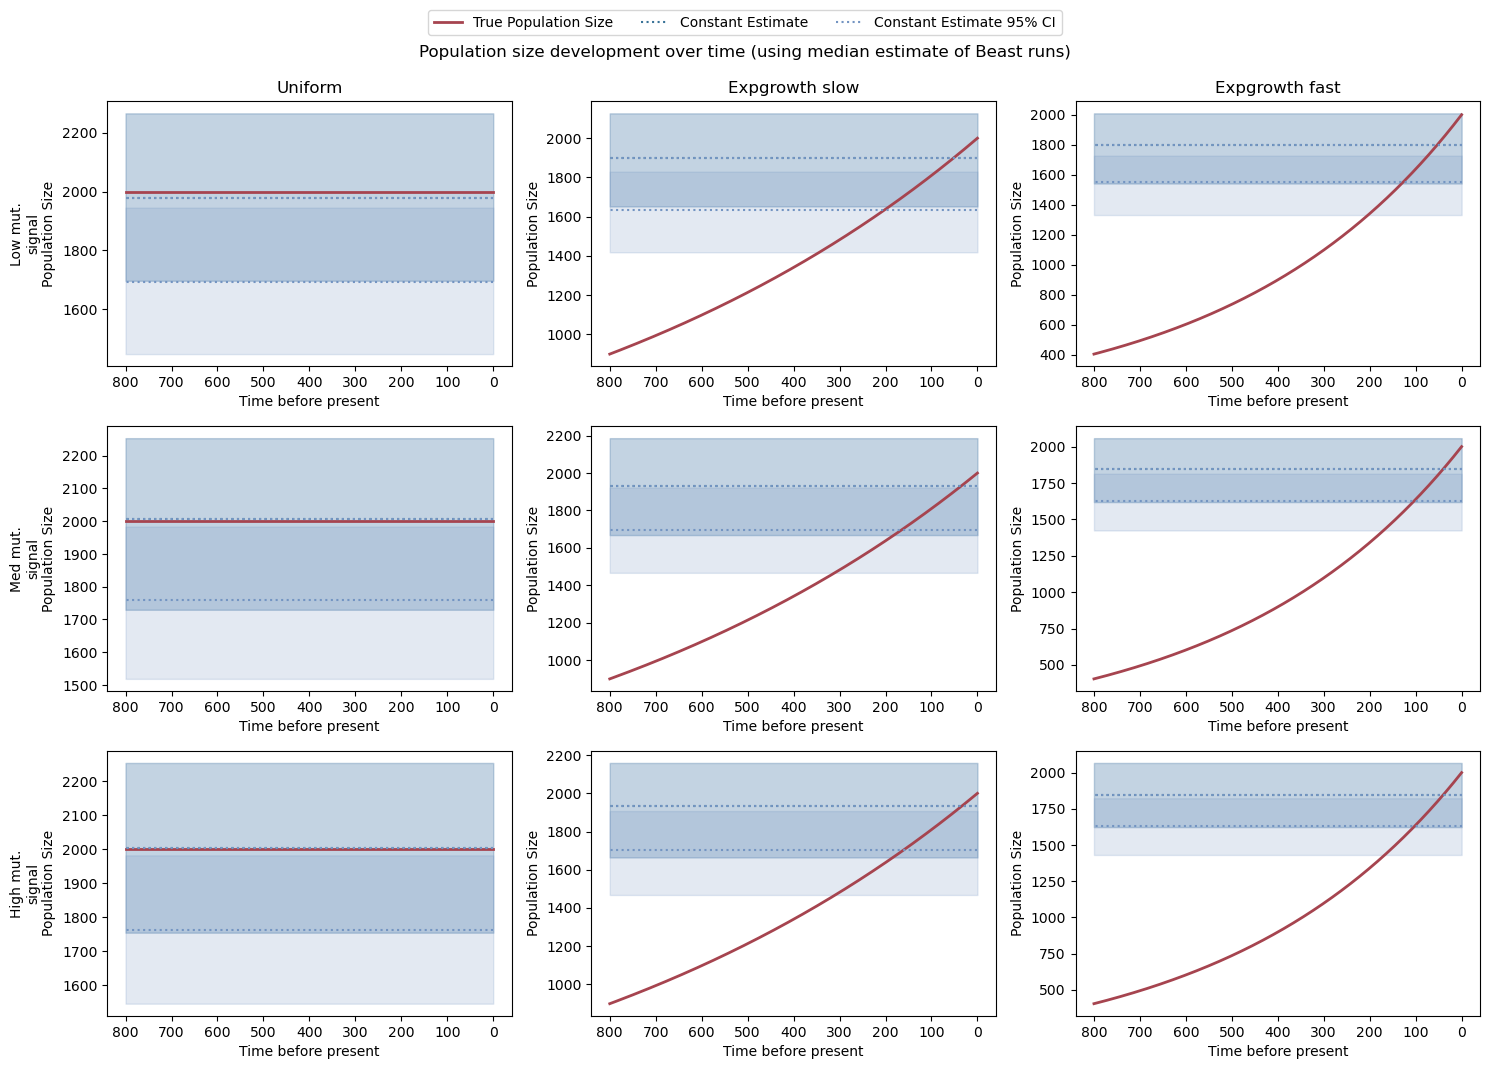

In [72]:
plot_population_summary_95cf(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)', mode = 'constcoal', plot_true_size=True)

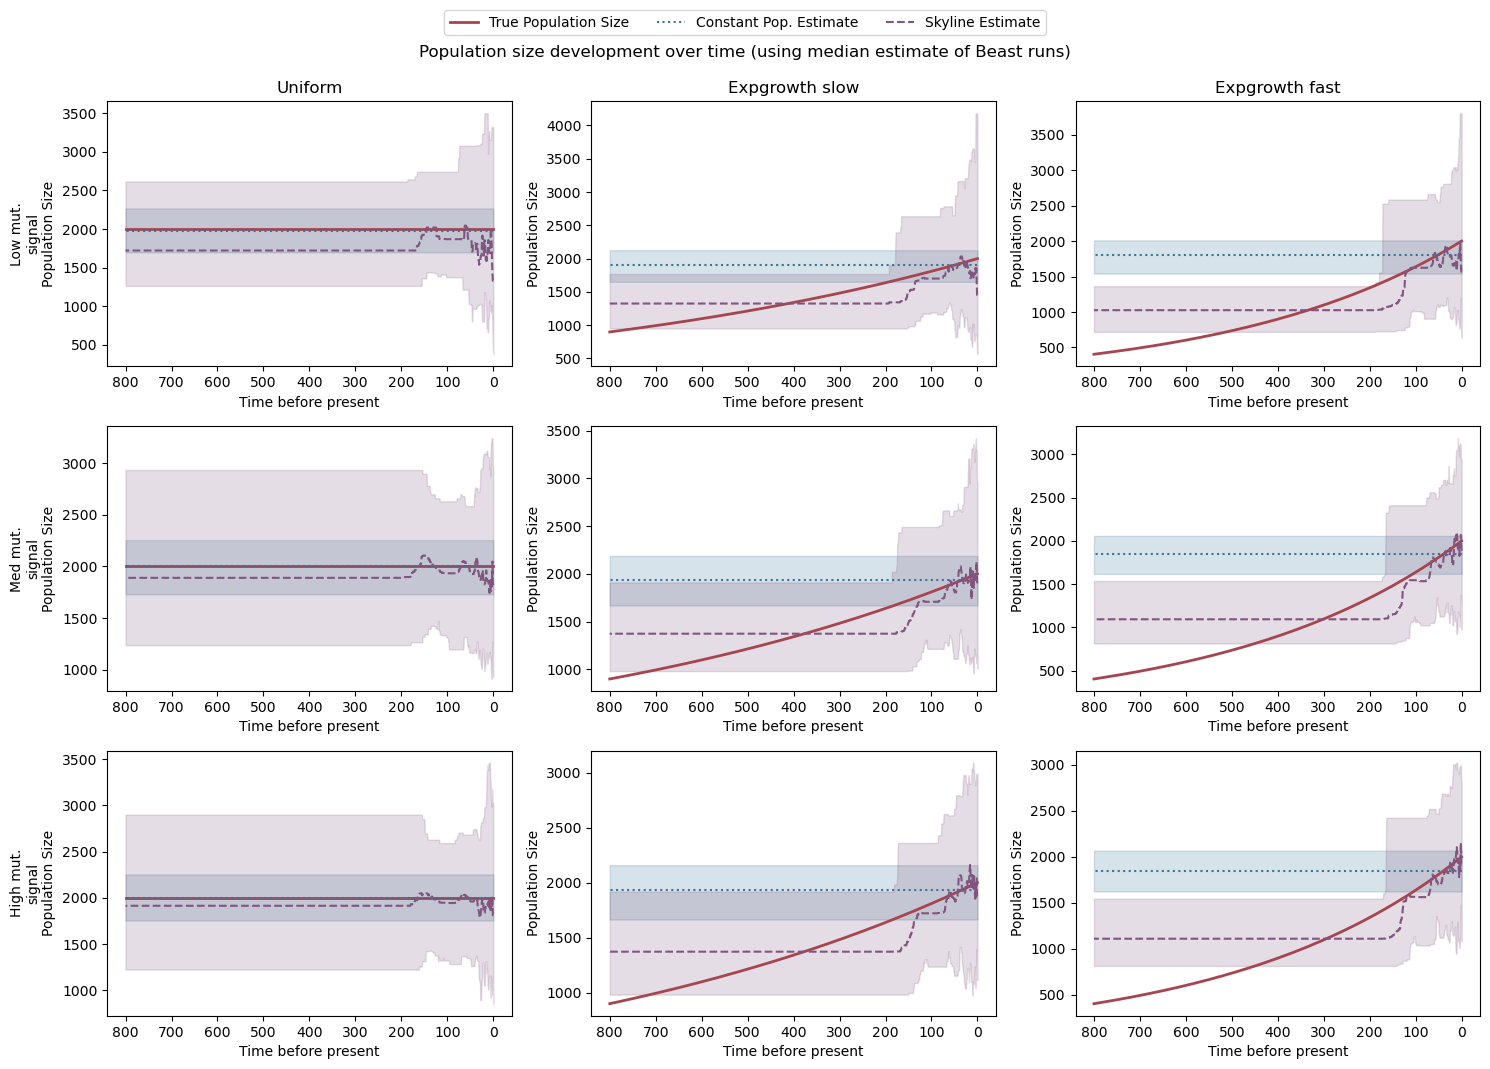

In [60]:
plot_population_summary(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)')

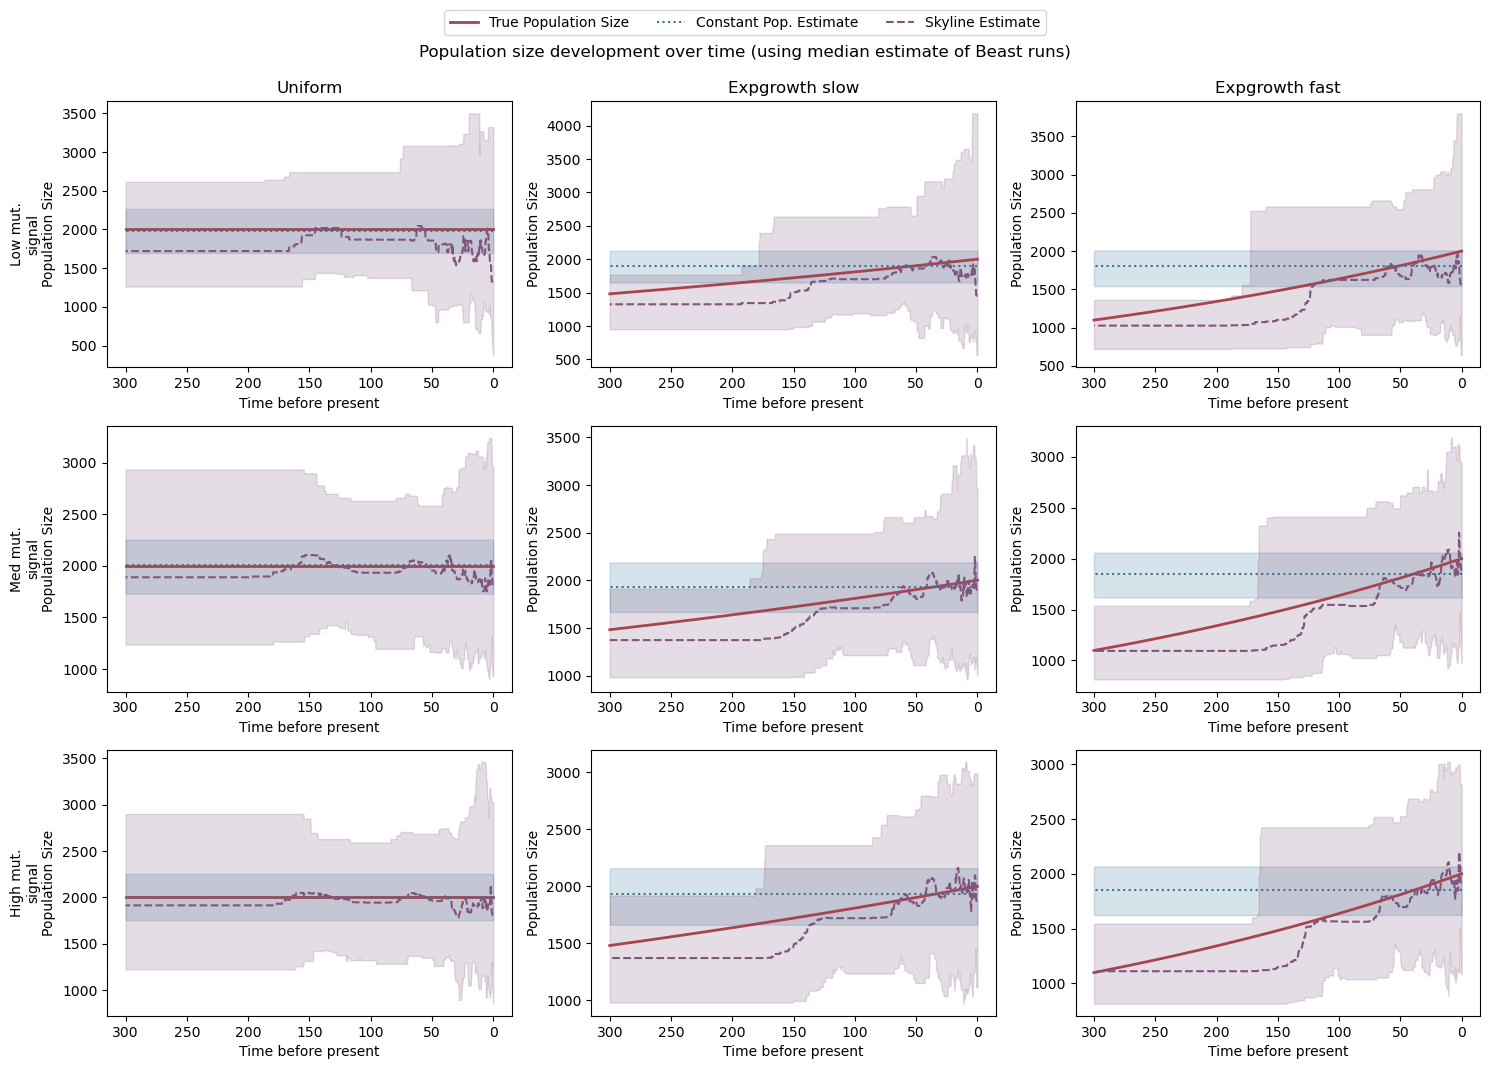

In [61]:
plot_population_summary(df_, time_horizon=300, title = 'Population size development over time (using median estimate of Beast runs)')

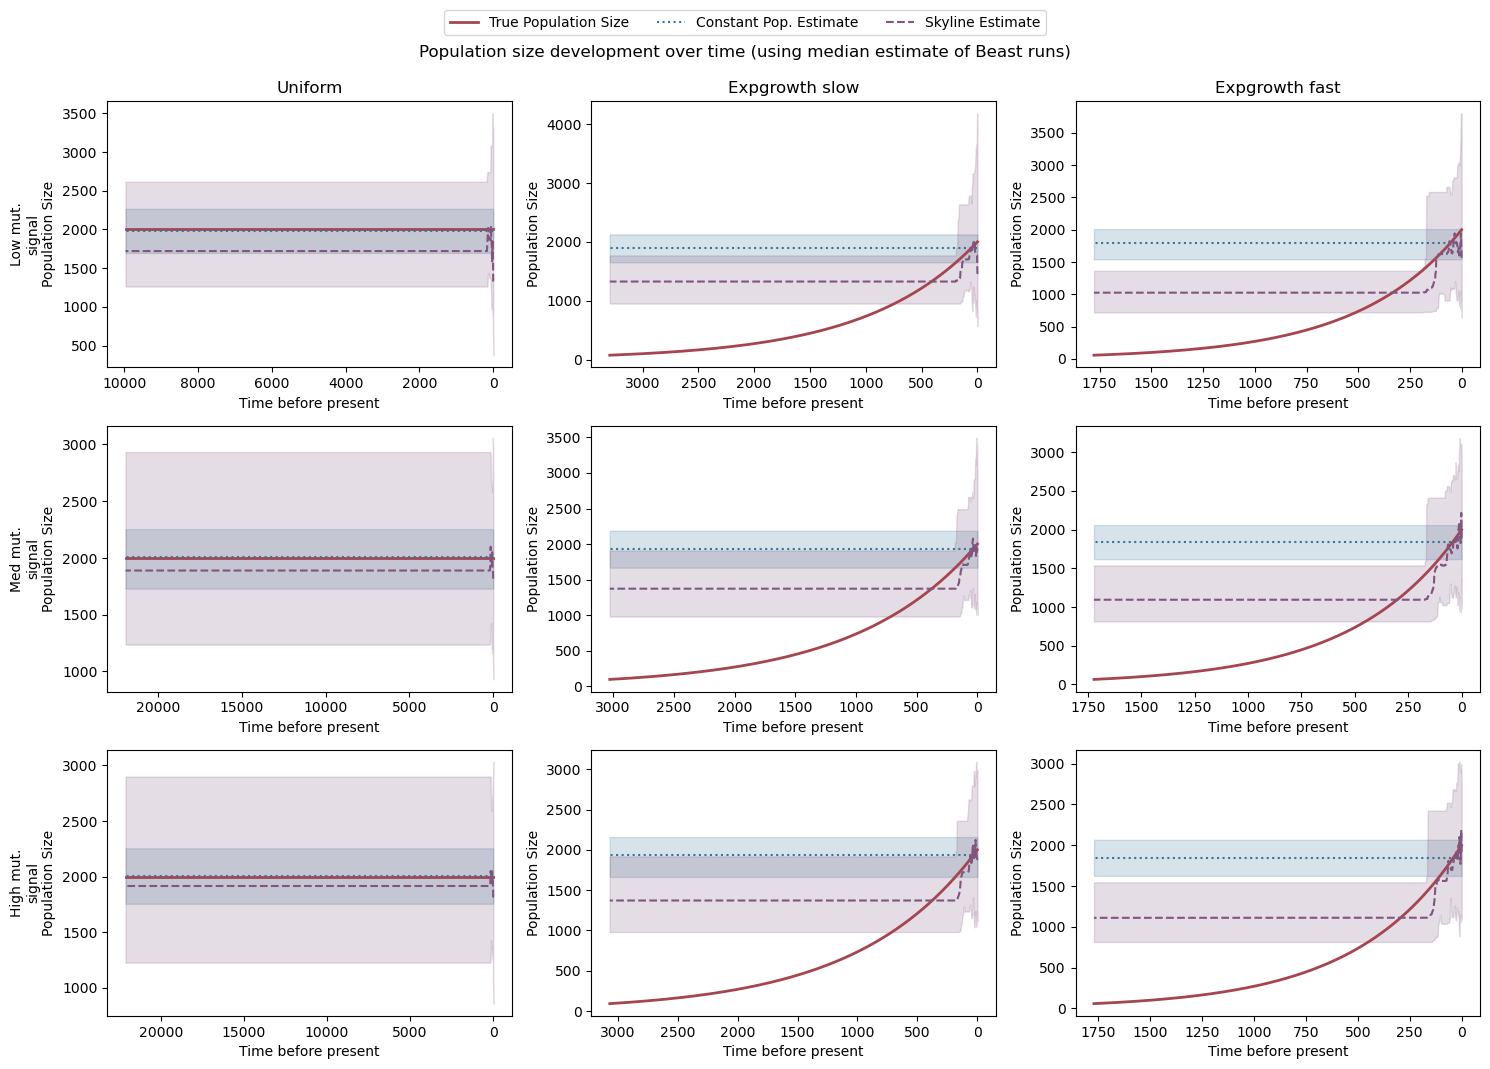

In [62]:
plot_population_summary(df_, time_horizon=0, title = 'Population size development over time (using median estimate of Beast runs)')

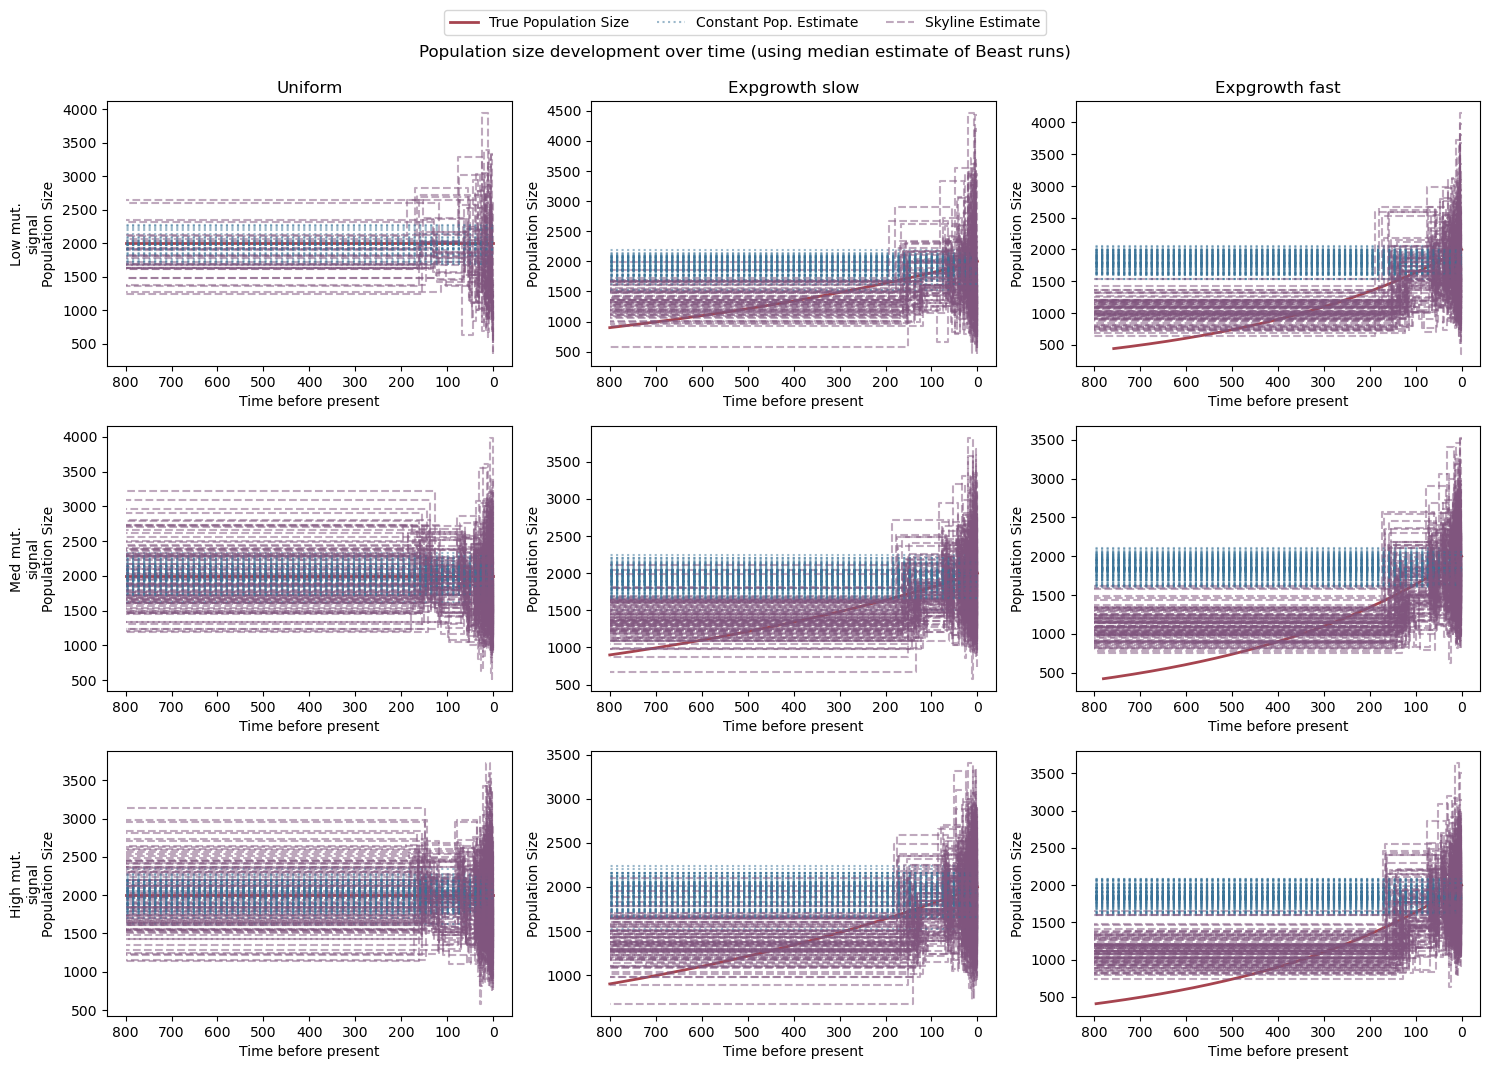

In [32]:
plot_summary_population_grid(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)')

## Evaluate error in population size

In [23]:
df_

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline,skyline_medians,skyline_times,coalescent_median
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1549.5420497587572, 1208.2955073155356, 2090....","[1.5031879938469501, 2.825459449616119, 6.2356...",1623.217071
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2599.2202372887537, 2154.8986913825697, 2301....","[2.4304536409420052, 4.878242197413556, 8.3809...",1957.851751
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2688.01735649332, 1352.1973882822972, 1511.50...","[2.4336367009808555, 4.3274500237843085, 6.082...",1993.191423
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1793.8474528508673, 1895.2618395529505, 2350....","[1.688498162637643, 3.930649310852914, 7.19952...",1900.630980
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1680.1590236804636, 1684.305959318696, 2227.8...","[1.584076672179549, 3.069221429993945, 7.06828...",1703.652888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,uniform,med,94,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.000,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1743.3963489297978, 1796.3509492242842, 2043....","[1.6768125695057279, 3.867315617550503, 6.7914...",2053.998486
896,uniform,med,96,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.000,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[3150.732323867582, 2565.8283890969124, 1687.7...","[2.8490851513952293, 6.6268782843496865, 8.633...",2008.480783
897,uniform,med,97,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.000,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1432.1818247661977, 3022.846316502263, 1408.3...","[1.0814751139969303, 4.927402255128982, 7.2455...",2141.569426
898,uniform,med,98,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.000,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2473.684489622462, 1627.9122715025571, 1697.7...","[2.547282473127325, 4.576160058691585, 6.87034...",2084.622011


In [24]:
df_complete = add_tree_information(df_)      
df_complete.head()   

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline,skyline_medians,skyline_times,coalescent_median,skyline_medians,skyline_times,coalescent_median
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1549.5420497587572, 1208.2955073155356, 2090....","[1.5031879938469501, 2.825459449616119, 6.2356...",1623.217071,"[1549.5420497587572, 1208.2955073155356, 2090....","[1.5031879938469501, 2.825459449616119, 6.2356...",1623.217071
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2599.2202372887537, 2154.8986913825697, 2301....","[2.4304536409420052, 4.878242197413556, 8.3809...",1957.851751,"[2599.2202372887537, 2154.8986913825697, 2301....","[2.4304536409420052, 4.878242197413556, 8.3809...",1957.851751
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2688.01735649332, 1352.1973882822972, 1511.50...","[2.4336367009808555, 4.3274500237843085, 6.082...",1993.191423,"[2688.01735649332, 1352.1973882822972, 1511.50...","[2.4336367009808555, 4.3274500237843085, 6.082...",1993.191423
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1793.8474528508673, 1895.2618395529505, 2350....","[1.688498162637643, 3.930649310852914, 7.19952...",1900.630980,"[1793.8474528508673, 1895.2618395529505, 2350....","[1.688498162637643, 3.930649310852914, 7.19952...",1900.630980
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1680.1590236804636, 1684.305959318696, 2227.8...","[1.584076672179549, 3.069221429993945, 7.06828...",1703.652888,"[1680.1590236804636, 1684.305959318696, 2227.8...","[1.584076672179549, 3.069221429993945, 7.06828...",1703.652888
